## 05.DBSCAN(Density Based Spatial Clustering of Application with Noise)
#### DBSCAN 개요
- 특정 공간 내에 데이터 밀도 차이를 기반 알고리즘으로 함 -> 복잡한 기하학적 분포도를 가진 데이터 세트에 대해 군집화 잘 수행
- 간단하고 직관적인 알고리즘
  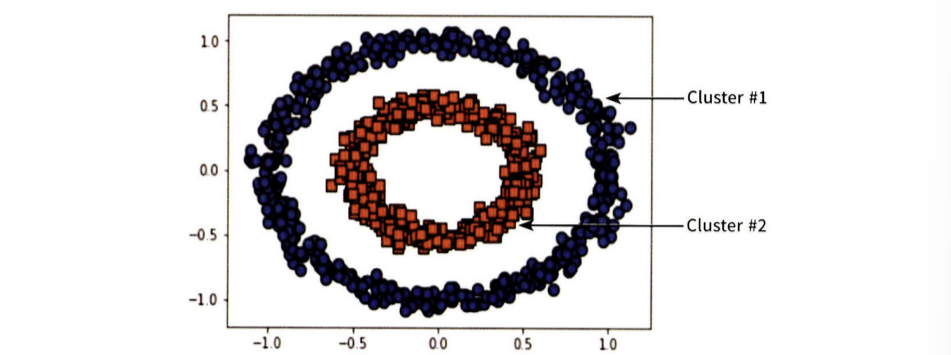
- 군집의 개수 자동 지정 -> 군집 개수 지정은 무의미 
- 중요한 파라미터
  - 입실론 주변 영역(epsilon): 개별 데이터를 중심으로 입실론 반경을 가지는 원형의 영역
    - eps: 입실론 주변 영역의 반경
  - 최소 데이터 개수(min points): 개별 데이터의 입실론 주변 영역에 포함되는 타 데이터의 개수
    - min_samples: 핵심포인트가 되기 위해 입실론 주변 영역 내에 포함되어야할 데이터의 최소 개수 (자신의 데이터 포함 : minpoints+1)
- eps의 값을 크게 하면 반경이 커져 포함하는 데이터가 많아지므로 노이즈 데이터 개수가 작아짐 
- 데이터 포인트
  - 핵심 포인트: 주변 영역내에 최소 데이터 개수 이상의 타 데이터 소유 
  - 이웃 포인트: 주변 영역 내에 위치한 타 데이터 
  - 경계 포인트: 주변 영역 내에 최소 데이터 개수 이상의 이웃포인트X but 핵심포인트를 이웃포인트로 갖고 O 데이터
  - 잡음 포인트: 최소 데이터 개수 이상의 이웃 포인트X, 핵심포인트도 이웃 포인트로 X
  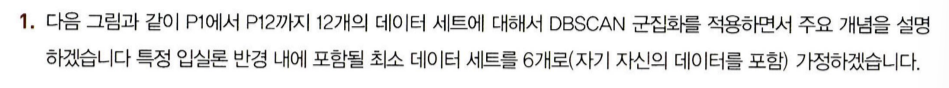
    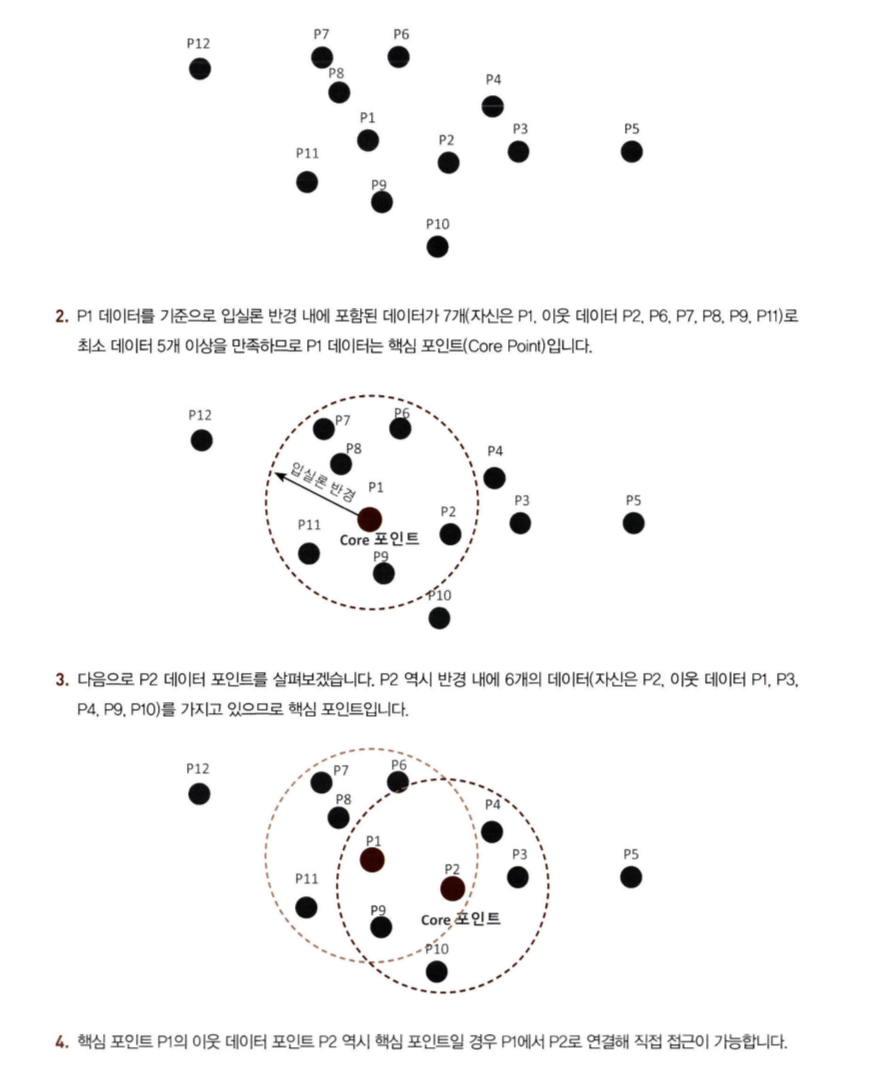
    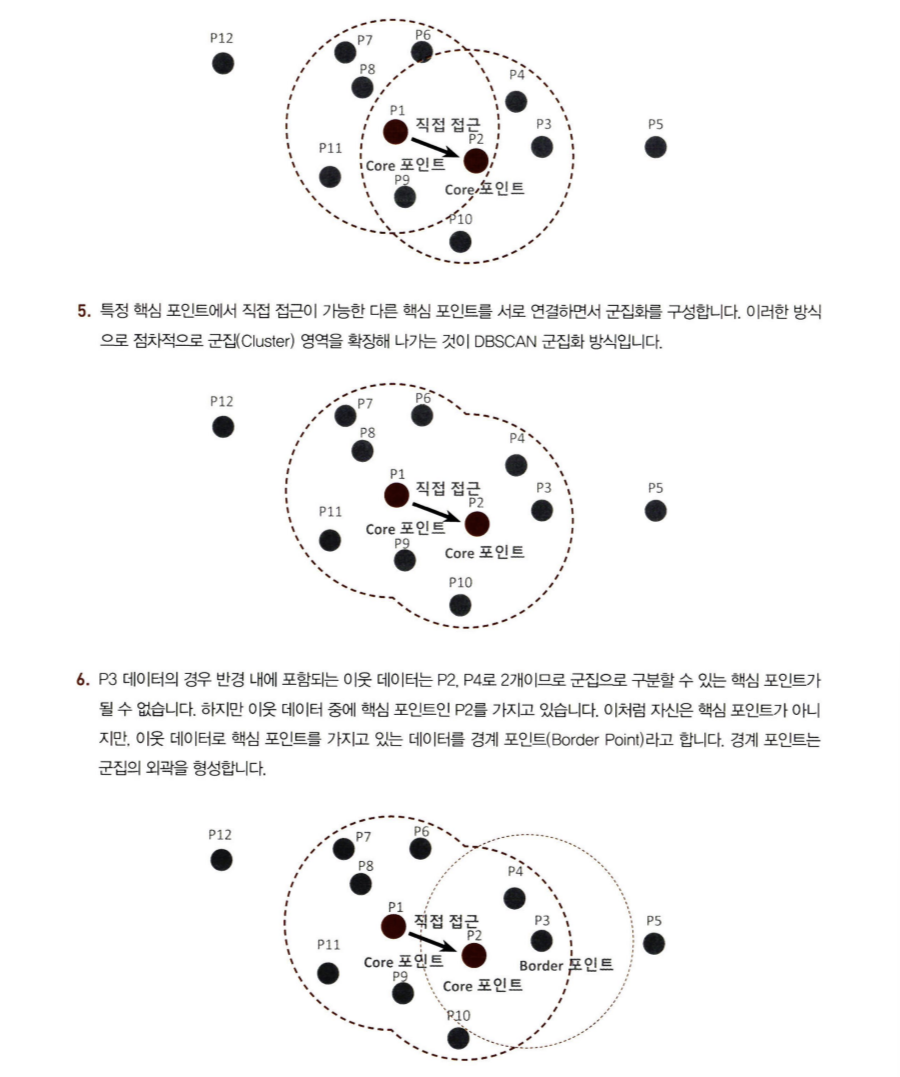
    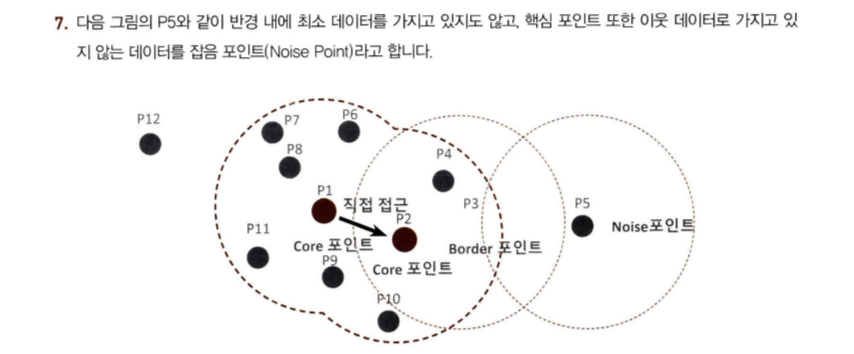  
=> 입실론 주변 영역의 최소 데이터 개수를 포함하는 밀도 기준을 충족시키는 데이터인 핵심 포인트 연결 -> 군집화 구성 

#### DBSCAN 적용하기 - 붓꽃 데이터 세트

In [13]:
from sklearn.datasets import load_iris

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

iris = load_iris()
feature_names = ['sepal_length','sepal_width','petal_length','petal_width']

# 보다 편리한 데이타 Handling을 위해 DataFrame으로 변환
irisDF = pd.DataFrame(data=iris.data, columns=feature_names)
irisDF['target'] = iris.target

In [14]:
from sklearn.cluster import DBSCAN

dbscan=DBSCAN(eps=0.6, min_samples=8, metric='euclidean')
dbscan_labels = dbscan.fit_predict(iris.data)

irisDF['dbscan_cluster'] = dbscan_labels
irisDF['target'] = iris.target

iris_result = irisDF.groupby(['target'])['dbscan_cluster'].value_counts()
print(iris_result)

target  dbscan_cluster
0        0                49
        -1                 1
1        1                46
        -1                 4
2        1                42
        -1                 8
Name: count, dtype: int64


*군집레이블 -1: 노이즈에 속하는 군집 

- PCA이용해 2개의 피처로 압축 변환 후 visualize_cluster_plot() 함수 이용하여 시각화 : 2차원 평면에 군집화 데이터 표현 

In [15]:
### 클러스터 결과를 담은 DataFrame과 사이킷런의 Cluster 객체등을 인자로 받아 클러스터링 결과를 시각화하는 함수  
def visualize_cluster_plot(clusterobj, dataframe, label_name, iscenter=True):
    if iscenter :
        centers = clusterobj.cluster_centers_
        
    unique_labels = np.unique(dataframe[label_name].values)
    markers=['o', 's', '^', 'x', '*']
    isNoise=False

    for label in unique_labels:
        label_cluster = dataframe[dataframe[label_name]==label]
        if label == -1:
            cluster_legend = 'Noise'
            isNoise=True
        else :
            cluster_legend = 'Cluster '+str(label)
        
        plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], s=70,\
                    edgecolor='k', marker=markers[label], label=cluster_legend)
        
        if iscenter:
            center_x_y = centers[label]
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=250, color='white',
                        alpha=0.9, edgecolor='k', marker=markers[label])
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k',\
                        edgecolor='k', marker='$%d$' % label)
    if isNoise:
        legend_loc='upper center'
    else: legend_loc='upper right'
    
    plt.legend(loc=legend_loc)
    plt.show()

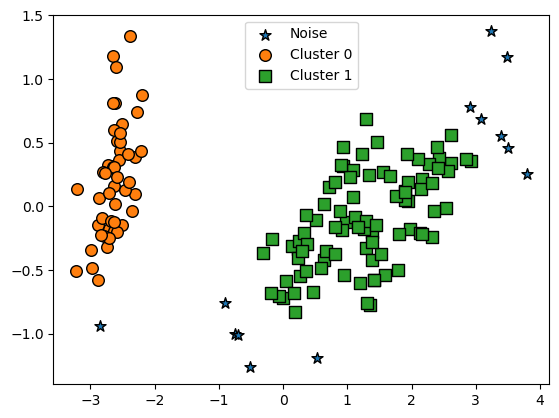

In [16]:
from sklearn.decomposition import PCA
# 2차원으로 시각화하기 위해 PCA n_components=2로 피처 ㅔ이터 세트 변환
pca=PCA(n_components=2, random_state=0)
pca_transformed = pca.fit_transform(iris.data)
# visualize_cluster_2d() 함수는 ftr1, ftr2 칼럼을 좌표에 표현하므로 PCA 변환값을 해당 칼럼으로 생성
irisDF['ftr1']=pca_transformed[:,0]
irisDF['ftr2']=pca_transformed[:,1]

visualize_cluster_plot(dbscan, irisDF, 'dbscan_cluster', iscenter=False)

-> PCA로 2차원으로 표현 -> 이상치(노이즈 데이터) 명확히 드러남   
-> 적절한 파라미터를 통한 최적 군집 찾기가 중요 

- eps 증가: 0.6 -> 0.8

target  dbscan_cluster
0        0                50
1        1                50
2        1                47
        -1                 3
Name: count, dtype: int64


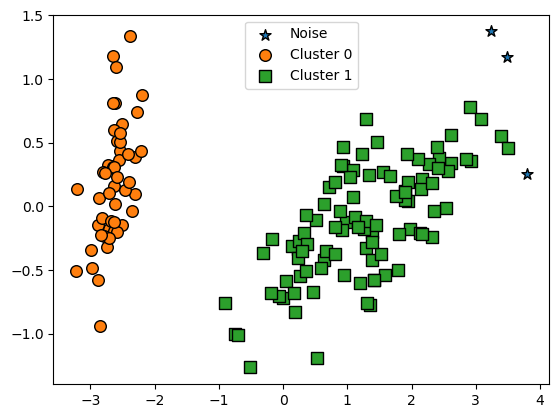

In [17]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.8, min_samples=8, metric='euclidean')
dbscan_labels = dbscan.fit_predict(iris.data)

irisDF['dbscan_cluster'] = dbscan_labels
irisDF['target'] = iris.target

iris_result = irisDF.groupby(['target'])['dbscan_cluster'].value_counts()
print(iris_result)

visualize_cluster_plot(dbscan, irisDF, 'dbscan_cluster', iscenter=False)

target  dbscan_cluster
0        0                48
        -1                 2
1        1                44
        -1                 6
2        1                36
        -1                14
Name: count, dtype: int64


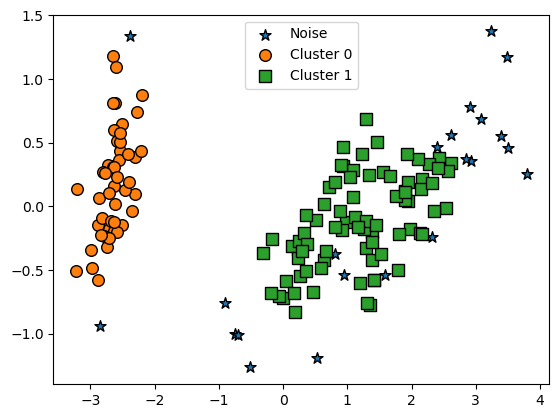

In [18]:
dbscan = DBSCAN(eps=0.6, min_samples=16, metric='euclidean')
dbscan_labels = dbscan.fit_predict(iris.data)

irisDF['dbscan_cluster'] = dbscan_labels
irisDF['target'] = iris.target

iris_result = irisDF.groupby(['target'])['dbscan_cluster'].value_counts()
print(iris_result)

visualize_cluster_plot(dbscan, irisDF, 'dbscan_cluster', iscenter=False)

-> 노이즈 데이터가 기존 보다 맣이 증가

#### DBSCAM 적용하기-make_circles() 데이터 세트

- 내부 원과 외부 원 형태의 2차원 데이터 세트 생성: factor-외부 원과 내부 원의 scale 비율 

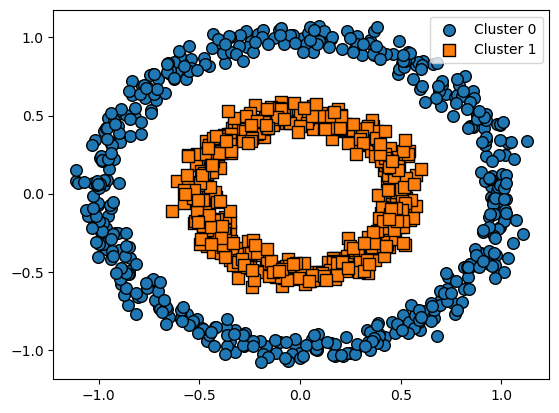

In [19]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000, shuffle=True, noise=0.05, random_state=0, factor=0.5)
clusterDF = pd.DataFrame(data=X, columns=['ftr1','ftr2'])
clusterDF['target']=y

visualize_cluster_plot(None, clusterDF, 'target', iscenter=False)

- K-평균으로 make_circles() 데이터 세트 군집화

C:\Users\leehj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\leehj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


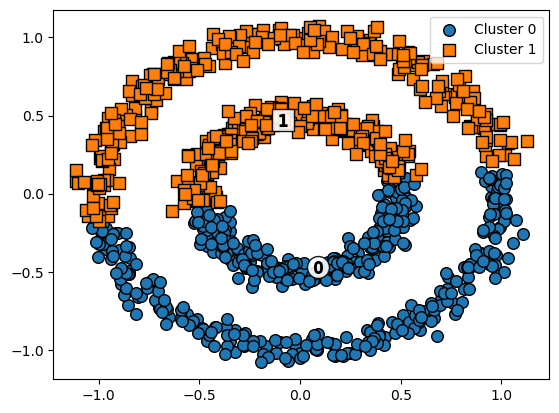

In [21]:
# KMeans로 make_circles() 데이터 세트 군집화 수행.
from sklearn.cluster import KMeans

kmeans=KMeans(n_clusters=2, max_iter=1000, random_state=0)
kmeans_labels=kmeans.fit_predict(X)
clusterDF['kmeans_cluster']=kmeans_labels

visualize_cluster_plot(kmeans, clusterDF, 'kmeans_cluster', iscenter=True)

-> 위, 아래 군집 중심을 기반으로 위와 아래 절반으로 군집화 -> 지속해서 이어지는 부분 찾아내기 어려움

C:\Users\leehj\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


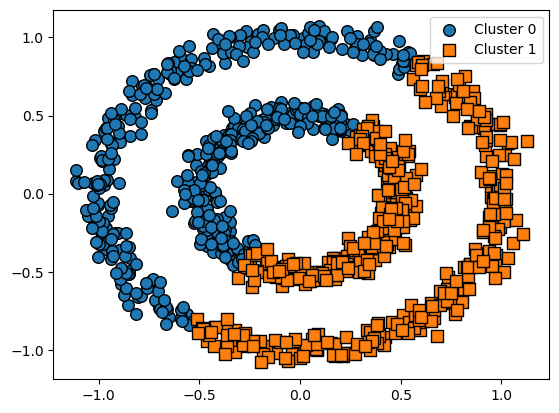

In [22]:
# GMM으로 make_circles() 데이터 세트를 군집화 수행.
from sklearn.mixture import GaussianMixture

gmm=GaussianMixture(n_components=2, random_state=0)
gmm_label = gmm.fit(X).predict(X)
clusterDF['gmm_cluster']=gmm_label

visualize_cluster_plot(gmm, clusterDF, 'gmm_cluster', iscenter=False)

-> 내부와 외부의 원형으로 구성된 복잡한 형태의 데이터세트는 원하ㅡㄴ 방향으로 군집화X

- DBSCAN으로 군집화

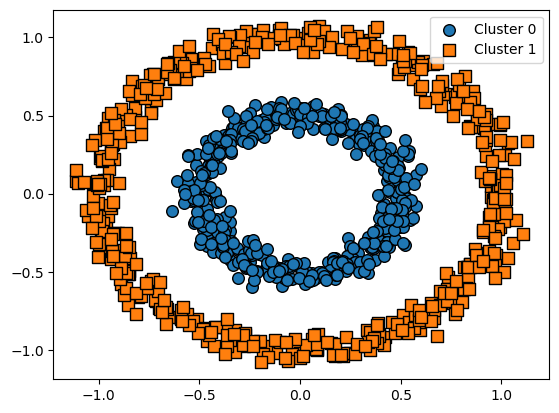

In [24]:
# DBSCAN으로 make_circles() 데이터 세트 군집화 수행.
from sklearn.cluster import DBSCAN

dbscan=DBSCAN(eps=0.2, min_samples=10, metric='euclidean')
dbscan_labels = dbscan.fit_predict(X)
clusterDF['dbscan_cluster'] = dbscan_labels
visualize_cluster_plot(dbscan, clusterDF, 'dbscan_cluster', iscenter=False)

-> 원하는 방향으로 정확히 군집화 됨